* C-shunted profiling
* Inbuilt-Symmetry model
* Uniform Initialization, Optimal Enclosure : 2dim=5x5 ; 4dim=3x3x3x3
* Parameter subspace : I : fixed : 800GHz
    - A : J1==J3 / J2 ; C1==C3 = 600GHz, C2 = 10GHz
    - B : C1==C3 / C2 ; J1==J3 = 150GHz, J2 = 100GHz
    - C : J1==J3 / C1==C3 ; J2 = 100GHz, C2 = 10GHz
    - D : J1==J3 / J2 / C1==C3 / C2
* Algorithms :
    - SGD : learning rate={.01,.0001} : SGD2,SGD4 :
    - Adam : learning rate={.01,.0001} : Adam2,Adam4
    - Nelder Mead : !!! Unconstrained Symmetry on Nelder Mead
    - Conjugate Gradient !!! Unconstrained Symmetry on Nelder Mead
    - L-BFGS :
        - scipy : *assummed Wolfe
        - torch : Wolfe
        - torch : lr = .0001
* Benchmarkers Optimization : multi-initialization
    - Loss : min,max,avg : Box Plots
    - Termination : count,steps:min,max,avg

* SGDx, Adam4 are too slow
* Wolfe torch LBFGS : stagnation

In [1]:
from multiprocess import Pool
#from multiprocessing import Pool
from DiSuQ.Torch.optimization import uniformParameters,initializationParallelism,truncNormalParameters,initializationSequential
from DiSuQ.Torch import models
from DiSuQ.Torch.components import J0,L0,C0
from DiSuQ.Torch import optimization
from DiSuQ.Torch.optimization import lossTransition
from scipy.optimize import LinearConstraint
from torch import tensor, float32 as float
from numpy import arange,linspace,array,argsort,vstack,isnan
from DiSuQ.utils import plotCompare,plotOptimization,plotBox,plotHeatmap
import pickle
from torch import set_num_threads
set_num_threads(32)

In [2]:
with open('../C-shuntedProfiling/target_fluxqubit.p', 'rb') as content: target_info = pickle.load(content)
target_spectrum = target_info['spectrum']
E10 = target_spectrum[:,1] - target_spectrum[:,0]
E20 = target_spectrum[:,2] - target_spectrum[:,0]
target = {'E10':E10[[0,20,-1]],'E20':E20[[0,20,-1]]}

In [3]:
Algo = ["Adam2","lrBFGS",'Nelder-Mead','LBFGS']

In [4]:
lossFunction = lossTransition(tensor(target['E10'],dtype=float),tensor(target['E20'],dtype=float))

In [5]:
iterations = 5; n_scape = 50

In [6]:
flux_range = linspace(0,1,3,endpoint=True)
flux_profile = [{'I':flux} for flux in flux_range]

In [7]:
symmetry = array([[1,0,0,0,-1,0,0],[0,1,0,0,0,-1,0]])
symmetry = LinearConstraint(symmetry,[0,0],[0,0])

In [8]:
def printLog(dLog):
    print(dLog['loss'].iloc[-1])

In [9]:
def benchmarking(optimizer,initials,subspace):
    Adam2,lrBFGS,NelMea,LBFGS = [],[],[],[]
    for index,parameter in enumerate(initials):
        print(index,'-------------------------------------------------')
        print(parameter)
        # scipy-BFGS
        print('L-BFGS')
        optimizer.circuit.initialization(parameter)  
        print(optimizer.circuitState())
        optimizer.parameters,optimizer.IDs = optimizer.circuitParameters(subspace)
        LBFGS.append(optimizer.minimization(lossFunction,flux_profile,subspace=subspace,
                                           method='L-BFGS-B',options=dict(ftol=1e-6,maxiter=iterations)))
        
        # Adam
        print('Adam')
        optimizer.circuit.initialization(parameter)
        optimizer.parameters,optimizer.IDs = optimizer.circuitParameters(subspace)
        Adam2.append(optimizer.optimization(lossFunction,flux_profile,iterations=iterations,lr=.01))
        
#         optimizer.circuit.initialization(parameter)
#         optimizer.parameters,optimizer.IDs = optimizer.circuitParameters(subspace)
#         Adam4.append(optimizer.optimization(lossFunction,flux_profile,iterations=iterations,lr=.0001))
        
        # Nelder Mead
        print('Nelder Mead')
        optimizer.circuit.initialization(parameter)
        optimizer.parameters,optimizer.IDs = optimizer.circuitParameters(subspace)
        NelMea.append(optimizer.minimization(lossFunction,flux_profile,subspace=subspace,
                                             method='Nelder-Mead',options=dict(fatol=1e-6)))
        
#         Conjugate Gradient
#         print('Conjugate Gradient')
#         optimizer.circuit.initialization(parameter)
#         optimizer.parameters,optimizer.IDs = optimizer.circuitParameters(subspace)
#         CG.append(optimizer.minimization(lossFunction,flux_profile,subspace=subspace,
#         method='CG',tol=1e-8,maxiter=iterations))
        
#         # Wolfe BFGS
#         print('Wolfe BFGS')
#         optimizer.circuit.initialization(parameter)     
#         optimizer.parameters,optimizer.IDs = optimizer.circuitParameters(subspace)        
#         Wolfe.append(optimizer.optimizationLBFGS(lossFunction,flux_profile,iterations=iterations))
        
        # lr-LBFGS
        print('lr LBFGS')
        optimizer.circuit.initialization(parameter)
        optimizer.parameters,optimizer.IDs = optimizer.circuitParameters(subspace)
        lrBFGS.append(optimizer.optimizationLBFGS(lossFunction,flux_profile,iterations=iterations,lr=.1))
        
        
    return Adam2,lrBFGS,NelMea,LBFGS

In [10]:
def optimizationAnalysis(init,subspace,Search,success=1.):
    Loss,Success,Paths = [],[],[]
    for index,(init,(dLogs,dParams,dCircuit)) in enumerate(zip(init,Search)):
        Paths.append(dCircuit[subspace].to_numpy())
        loss = dLogs['loss'].to_numpy()
        Loss.append(loss[-1])
        if loss[-1] < success:
            Success.append(len(loss))
    return Paths,Loss,Success

In [118]:
def analysisPlotting(Optimization):
    paths = dict()
    losse = dict()
    for algo,(Paths,Loss,Success) in zip(Algo,Optimization):
        index = argsort(Loss)[0]
        #print(Loss[index]);print(index)
        paths[algo] = Paths[index]
        #print(Paths[index][-1])
        losse[algo] = Loss
    return paths,losse

In [12]:
def lossScapeBounds(paths):
    Paths = []
    for algo,path in paths.items():
        Paths.append(path)
    Paths = vstack(Paths)
    Paths = Paths[:, ~isnan(Paths).any(axis=0)]
    return Paths.min(0),Paths.max(0)

### simulation

#### subspace B

In [13]:
basis = {'O':[8],'J':[6,6],'I':[]}; rep = 'K'
C12 = .5 ; C22 = 20. ; C11 = C22
JJ1 = 150; JJ3 = 150 ; JJ2 = 50
ind = 800
circuit = models.shuntedQubit(basis,josephson=[JJ1,JJ2,JJ3],cap=[C11,C12,C22],ind=ind,sparse=False,symmetry=True)
static = circuit.circuitState()

In [14]:
optimizer = optimization.OrderingOptimization(circuit,representation=rep)

In [15]:
subspace = ['C1','C2'] ; N = 5
initials = uniformParameters(circuit,subspace,N)
#initials = truncNormalParameters(circuit,subspace,N,var=5)
len(initials)

25

In [ ]:
OptimizationB = benchmarking(optimizer,initials,subspace)
Adam2,lrBFGS,NelMea,LBFGS = OptimizationB

0 -------------------------------------------------
{'JJ1': 150.0, 'C1': 416.6666666666667, 'JJ2': 50.0, 'C2': 416.6666666666667, 'JJ3': 150.0, 'C3': 20.000001907348633, 'I': 800.0}
L-BFGS
{'JJ1': 150.0, 'C1': 416.66668701171875, 'JJ2': 50.0, 'C2': 416.66668701171875, 'JJ3': 150.0, 'C3': 416.66668701171875, 'I': 800.0}
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10226D+06    |proj g|=  4.16667D+02

At iterate    1    f=  9.61145D+05    |proj g|=  2.91082D+02

At iterate    2    f=  2.76129D+05    |proj g|=  1.68226D+02

At iterate    3    f=  1.08290D+05    |proj g|=  1.14435D+02


In [ ]:
Result = [optimizationAnalysis(initials,subspace,algo) for algo in OptimizationB]
paths,losse = analysisPlotting(Result)

In [ ]:
plotBox(losse,'Loss Distribution-C1-C2',size=(600,800))

In [ ]:
plotBox(losse,'Loss Distribution-C1-C2',export='pdf',size=(600,800))

In [ ]:
lower,upper = lossScapeBounds(paths)
lower = [1e-4,1e-4]
upper = [500,600]
C1 = linspace(lower[0],upper[0],n_scape,endpoint=True)
C2 = linspace(lower[1],upper[1],n_scape,endpoint=True)
scape = {'C1':C1,'C2':C2}

In [ ]:
flux_profile = [{'I':flux} for flux in flux_range]

In [ ]:
LossB = optimizer.lossScape(lossFunction,flux_profile,scape,static)

In [ ]:
plotOptimization(LossB,C1,C2,paths,'Optimization-C1_C2','C1(GHz)','C2(GHz)',export='pdf',size=(600,800),legend=False)

#### subspace C

In [ ]:
basis = {'O':[8],'J':[6,6],'I':[]}; rep = 'K'
C12 = .5 ; C22 = 20. ; C11 = C22
JJ1 = 150; JJ3 = 150 ; JJ2 = 50
ind = 800
circuit = models.shuntedQubit(basis,josephson=[JJ1,JJ2,JJ3],cap=[C11,C12,C22],ind=ind,sparse=False,symmetry=True)
static = circuit.circuitState()

In [ ]:
optimizer = optimization.OrderingOptimization(circuit,representation=rep)

In [ ]:
subspace = ['JJ1','C1'] ; N = 5
initials = uniformParameters(circuit,subspace,N)
#initials = truncNormalParameters(circuit,subspace,N,var=5)
len(initials)

In [ ]:
OptimizationC = benchmarking(optimizer,initials,subspace)
Adam2,lrBFGS,NelMea,LBFGS = OptimizationC

In [85]:
Result = [optimizationAnalysis(initials,subspace,algo) for algo in OptimizationC]
paths,losse = analysisPlotting(Result)

14
[[2.00000000e+02 5.00000000e+01 1.66666675e+03 4.99999881e-01]
 [2.01672226e+02 5.00000000e+01 1.66110193e+03 4.99999881e-01]
 [2.03356201e+02 5.00000000e+01 1.65551575e+03 4.99999881e-01]
 [2.05052017e+02 5.00000000e+01 1.64990784e+03 4.99999881e-01]
 [2.06760101e+02 5.00000000e+01 1.64427966e+03 4.99999881e-01]
 [2.08481369e+02 5.00000000e+01 1.63862524e+03 4.99999881e-01]]
14
[[2.00000000e+02 5.00000000e+01 1.66666675e+03 4.99999881e-01]
 [1.20000000e+03 5.00000000e+01 9.99999997e-07 4.99999881e-01]
 [1.20000000e+03 5.00000000e+01 9.99999997e-07 4.99999881e-01]
 [1.20000000e+03 5.00000000e+01 9.99999997e-07 4.99999881e-01]
 [1.20000000e+03 5.00000000e+01 9.99999997e-07 4.99999881e-01]
 [1.20000000e+03 5.00000000e+01 9.99999997e-07 4.99999881e-01]]
15
[[2.00000000e+02 5.00000000e+01 1.66666675e+03 4.99999881e-01]
 [2.10000000e+02 5.00000000e+01 1.66666675e+03 4.99999881e-01]
 [2.30000015e+02 5.00000000e+01 1.54166663e+03 4.99999881e-01]
 [2.30000015e+02 5.00000000e+01 1.54166663e+

In [ ]:
plotBox(losse,'Loss Distribution-JJ1-C1',export='pdf',size=(600,800))

In [ ]:
lower,upper = lossScapeBounds(paths)
JJ1 = linspace(lower[0],upper[0],n_scape,endpoint=True)
C1 = linspace(lower[1],upper[1],n_scape,endpoint=True)
scape = {'JJ1':JJ1,'C1':C1}

In [ ]:
flux_profile = [{'I':flux} for flux in flux_range]

In [ ]:
LossC = optimizer.lossScape(lossFunction,flux_profile,scape,static)

In [ ]:
plotOptimization(LossC,JJ1,C1,paths,'Optimization-JJ1_C1','JJ1(GHz)','C1(GHz)',export='pdf',size=(600,800),legend=False)

##### zooming in J1:(995,1005) * C1:(1220,1260)

In [86]:
lower,upper = lossScapeBounds(paths)
JJ1 = linspace(995,1005,n_scape,endpoint=True)
C1 = linspace(1220,1260,n_scape,endpoint=True)
scape = {'JJ1':JJ1,'C1':C1}

In [ ]:
flux_profile = [{'I':flux} for flux in flux_range]
LossZ = optimizer.lossScape(lossFunction,flux_profile,scape,static)

array([[2.54316068, 2.58349395, 2.34891224, ..., 2.33886623, 2.40108657,
        2.35654926],
       [2.65466475, 2.61133671, 2.36137438, ..., 2.31238079, 2.36378455,
        2.49126554],
       [2.43344021, 2.49633503, 2.33780503, ..., 2.28040004, 2.46827888,
        2.28722739],
       ...,
       [3.34061432, 3.26770353, 3.29785538, ..., 2.18916297, 2.2317338 ,
        2.53368068],
       [3.46245933, 3.25706577, 3.84552479, ..., 2.17654586, 2.16836929,
        2.10877204],
       [3.28033733, 3.15733624, 2.79758096, ..., 2.11442542, 2.19766021,
        2.25845003]])

In [ ]:
#del paths['Nelder-Mead'] # coloring !!
paths['Nelder-Mead'] = array([])

In [ ]:
plotOptimization(LossZ,JJ1,C1,paths,'Optimization-Details:JJ1_C1','JJ1(GHz)','C1(GHz)',export='pdf',size=(600,800),legend=False)

#### subspace A

In [ ]:
basis = {'O':[8],'J':[6,6],'I':[]}; rep = 'K'
C12 = .5 ; C22 = 20. ; C11 = C22
JJ1 = 150; JJ3 = 150 ; JJ2 = 50
ind = 800
circuit = models.shuntedQubit(basis,josephson=[JJ1,JJ2,JJ3],cap=[C11,C12,C22],ind=ind,sparse=False,symmetry=True)
static = circuit.circuitState()

In [ ]:
optimizer = optimization.OrderingOptimization(circuit,representation=rep)

In [ ]:
subspace = ['JJ1','JJ2'] ; N = 5
initials = uniformParameters(circuit,subspace,N)
#initials = truncNormalParameters(circuit,subspace,N,var=5)
len(initials)

In [ ]:
OptimizationA = benchmarking(optimizer,initials,subspace)
Adam2,lrBFGS,NelMea,LBFGS = OptimizationA

In [ ]:
Result = [optimizationAnalysis(initials,subspace,algo) for algo in OptimizationA]
paths,losse = analysisPlotting(Result)

In [ ]:
plotBox(losse,'Loss Distribution-JJ1-JJ2',export='pdf',size=(600,800))

In [ ]:
lower,upper = lossScapeBounds(paths)
JJ1 = linspace(lower[0],upper[0],n_scape,endpoint=True)
JJ2 = linspace(lower[1],upper[1],n_scape,endpoint=True)
scape = {'JJ1':JJ1,'JJ2':JJ2}

In [ ]:
flux_profile = [{'I':flux} for flux in flux_range]

In [ ]:
LossA = optimizer.lossScape(lossFunction,flux_profile,scape,static)

In [ ]:
plotOptimization(LossA,JJ1,JJ2,paths,'Optimization-JJ1_JJ2','JJ1(GHz)','JJ2(GHz)',export='pdf',size=(600,800),legend=False)

#### subspace D

In [94]:
import importlib
importlib.reload(models)

<module 'DiSuQ.Torch.models' from '/Users/chishti/JupyterHub/DiSuQ/Torch/models.py'>

In [95]:
basis = {'O':[8],'J':[6,6],'I':[]}; rep = 'K'
C12 = .5 ; C22 = 20. ; C11 = C22
JJ1 = 150; JJ3 = 150 ; JJ2 = 50
ind = 800
circuit = models.shuntedQubit(basis,josephson=[JJ1,JJ2,JJ3],cap=[C11,C12,C22],ind=ind,sparse=False,symmetry=True,
                             _C_=(.5e-4,2500))
static = circuit.circuitState()

In [96]:
optimizer = optimization.OrderingOptimization(circuit,representation=rep)

In [97]:
subspace = ['JJ1','JJ2','C1','C2'] ; N = 2
initials = uniformParameters(circuit,subspace,N)
#initials = truncNormalParameters(circuit,subspace,N,var=5)
len(initials)

16

In [98]:
OptimizationD = benchmarking(optimizer,initials[8:],subspace)
Adam2,lrBFGS,NelMea,LBFGS = OptimizationD

0 -------------------------------------------------
{'JJ1': 400.0, 'C1': 1666.6666666666667, 'JJ2': 400.0, 'C2': 833.3333333333334, 'JJ3': 150.0, 'C3': 20.000003814697266, 'I': 800.0}
L-BFGS
{'JJ1': 400.0, 'C1': 1666.666748046875, 'JJ2': 400.0, 'C2': 833.3333740234375, 'JJ3': 400.0, 'C3': 1666.666748046875, 'I': 800.0}
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42416D+07    |proj g|=  1.66667D+03

At iterate    1    f=  6.10462D+06    |proj g|=  1.11502D+03

At iterate    2    f=  1.32926D+05    |proj g|=  2.31881D+03

At iterate    3    f=  3.87278D+03    |proj g|=  1.79206D+02

At iterate    4    f=  3.38348D+03    |proj g|=  1.79060D+02

At iterate    5    f=  3.38339D+03    |proj g|=  1.79060D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored

/usr/local/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning:

Method Nelder-Mead does not use gradient information (jac).



Optimization terminated successfully.
         Current function value: 3356.735840
         Iterations: 122
         Function evaluations: 269
lr LBFGS
1 -------------------------------------------------
{'JJ1': 400.0, 'C1': 1666.6666666666667, 'JJ2': 400.0, 'C2': 1666.6666666666667, 'JJ3': 150.0, 'C3': 20.000003814697266, 'I': 800.0}
L-BFGS
{'JJ1': 400.0, 'C1': 1666.666748046875, 'JJ2': 400.0, 'C2': 1666.666748046875, 'JJ3': 400.0, 'C3': 1666.666748046875, 'I': 800.0}
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51636D+07    |proj g|=  1.66667D+03

At iterate    1    f=  1.38488D+07    |proj g|=  1.11204D+03

At iterate    2    f=  5.93465D+06    |proj g|=  7.64716D+02

At iterate    3    f=  1.90543D+06    |proj g|=  8.93503D+02

At iterate    4    f=  1.16134D+06    |proj g|=  2.06094D+03

At iterate    5    f=  2.69118D+05    |proj g|= 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49630D+07    |proj g|=  1.66667D+03

At iterate    1    f=  6.35812D+06    |proj g|=  1.11485D+03

At iterate    2    f=  3.35053D+06    |proj g|=  7.72129D+02

At iterate    3    f=  1.94076D+06    |proj g|=  5.47394D+02

At iterate    4    f=  1.24068D+06    |proj g|=  3.93688D+02

At iterate    5    f=  8.25874D+05    |proj g|=  1.12553D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     11      8     0     0   

In [119]:
Result = [optimizationAnalysis(initials,subspace,algo) for algo in OptimizationD]
paths,losse = analysisPlotting(Result)

13920898.0
4
[ 813.21838379  386.79177856 1638.65966797  805.79144287]
17158100.0
0
[9.99999997e-07 1.20000000e+03 4.99999987e-05 4.99999987e-05]
102.83589172363281
3
[  21.44665146 1200.            2.41201758  494.22122192]
3383.385009765625
0
[1.17833228e+03 1.87924728e+01 5.80824688e-02 1.79060181e+02]


In [100]:
plotBox(losse,'Loss Distribution',export='pdf',size=(600,800))

In [116]:
lrBFGS[0][2]

,JJ1,C1,JJ2,C2,JJ3,C3,I
0,4.000000e+02,1666.666748,400.0,833.333374,4.000000e+02,1666.666748,800.0
1,1.000000e-06,0.000050,1200.0,0.000050,1.000000e-06,0.000050,800.0
2,1.000000e-06,0.000050,1200.0,0.000050,1.000000e-06,0.000050,800.0
3,1.000000e-06,0.000050,1200.0,0.000050,1.000000e-06,0.000050,800.0
4,1.000000e-06,0.000050,1200.0,0.000050,1.000000e-06,0.000050,800.0
5,1.000000e-06,0.000050,1200.0,0.000050,1.000000e-06,0.000050,800.0


## Solution Aggregation

In [120]:
from DiSuQ.Torch.components import capE

In [124]:
from numpy import sqrt,stack,concatenate,pi; static

{'JJ1': 150.0,
 'C1': 20.000003814697266,
 'JJ2': 50.0,
 'C2': 0.4999997615814209,
 'JJ3': 150.0,
 'C3': 20.000003814697266,
 'I': 800.0}

In [125]:
from matplotlib import pyplot as plt
import matplotlib

In [151]:
point = static

In [152]:
Distance = []
Loss = []
Points = []

In [156]:
for Algo in OptimizationA:
    for index,(dLogs,dParams,dCircuit) in enumerate(Algo):
        loss = dLogs['loss'].to_numpy()
        distance = 0
        for dim,val in point.items():
            distance += (dCircuit[dim]-point[dim])**2
        distance = sqrt(distance)
        index = loss < 1
        Points.append(dCircuit.iloc[1:].to_numpy()[index])
        Loss.append(loss[index])
        Distance.append(distance.iloc[1:].to_numpy()[index])

In [157]:
concatenate(Loss).shape,concatenate(Distance).shape,concatenate(Points).shape

((517,), (517,), (517, 7))

In [158]:
from sklearn.cluster import KMeans
from numpy import around
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(concatenate(Points))
minima = kmeans.cluster_centers_

In [159]:
colors = ['blue','red','green','purple']

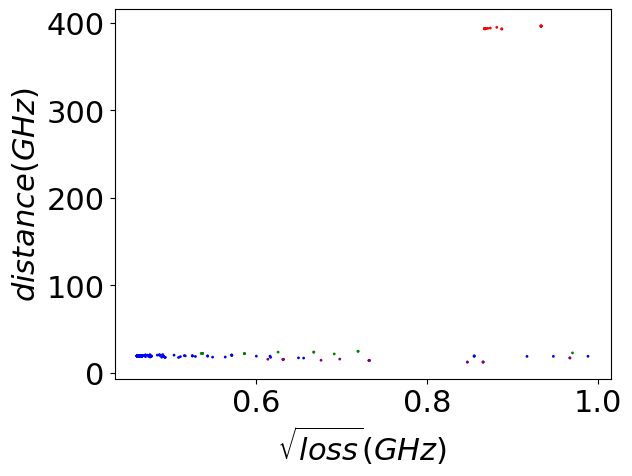

In [160]:
plt.rcParams.update({'font.size': 22})
plt.xlabel(r'$\sqrt{loss}(GHz)$')
plt.ylabel(r'$distance(GHz)$')
plt.scatter(sqrt(concatenate(Loss)),concatenate(Distance),s=1,c=kmeans.labels_,cmap=matplotlib.colors.ListedColormap(colors))
#plt.figure(figsize=(5,5))
plt.savefig('Loss-Distance.pdf',bbox_inches="tight")
#plt.show()